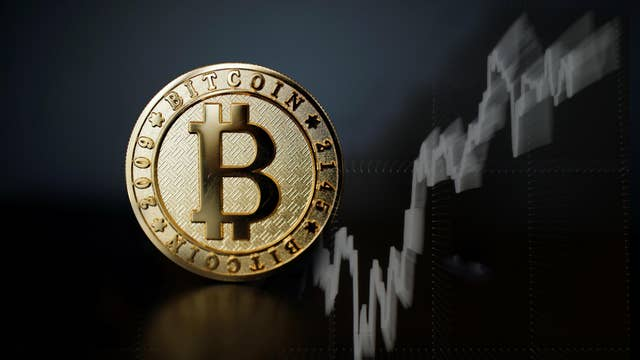

***Welcome to this notebook!***

Feel free to fork for your own learning and edit the code or use in your own submissions. If you found this notebook enriched and helps improving your learning in the slightest, please ***Upvote*** this notebook as an encouragement for me to continue writing notebooks! :)

# Table of Contents

* [Introduction](#section-one)
    - [First look](#subsection-one)
* [Handling Missing Values](#section-two)
* [Exploratory Data Analysis](#section-three)
    - [Lag Plots](#subsection-two)
    - [Time Resampling](#subsection-three)
* [Time Series Decomposition & Statistical Tests](#section-four)
    - [KPSS Test](#subsection-four)
    - [ADF Test](#subsection-five)
* [Feature Extraction](#section-five)
* [Model Building](#section-six)
    - [ARIMA](#subsection-six)
    - [FB Prophet](#subsection-seven)
    - [XG Boost](#subsection-eight)
    - [LSTM](#subsection-nine)
* [Model Selection](#section-seven)
* [Next Steps](#section-eight)

 <a id="section-one"></a>
# Introduction 

The first Bitcoin protocol and proof of concept was published in a Whitepaper in 2009 by a shadowy individual or group under the pseudonym Satoshi Nakamoto. Nakamoto, left the project in late 2010. Other developers took over and the Bitcoin community has since grown exponentially.

Bitcoin emerged out of the 2008 global economic crisis when big banks were caught misusing borrowers' money, manipulating the system, and charging exorbitant fees. To address such issues, Bitcoin creators wanted to put the owners of bitcoins in-charge of the transactions, eliminate the middleman, cut high interest rates and transaction fees, and make transactions transparent. They created a distributed network system, where people could control their funds in a transparent way.

However, there are issues with bitcoins such as hackers breaking into accounts, high volatility of bitcoins, and long transaction delays. Considering the volatility it's always challenging to predict the bitcoin price. 

In this notebook, we will be deep diving into the dataset, perform some EDA, feature engineering and will predict bitcoin price using Stochastic, Machine Learning and Deep Learning models. 

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
from itertools import product
import warnings
import statsmodels.api as sm
plt.style.use('seaborn-darkgrid')
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
#matplotlib inline

<a id="subsection-one"></a>
# A first look at Bitcoin Prices

Let’s check what the first 5 lines of our time-series data look like:

In [3]:
# Reading the csv file
bitstamp = pd.read_csv("../input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
bitstamp.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
bitstamp=bitstamp.iloc[:4572257,:]

Let us now look at the datatypes of the various components.

In [5]:
bitstamp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572257 entries, 0 to 4572256
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 279.1 MB


It appears that the Timestamp column is being treated as a integer rather than as dates. To fix this, we’ll use the fromtimestamp() function which converts the arguments to dates.

In [6]:
# Converting the Timestamp column from string to datetime
bitstamp['Timestamp'] = [datetime.fromtimestamp(x) for x in bitstamp['Timestamp']]

In [7]:
bitstamp.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print('Dataset Shape: ',  bitstamp.shape)

Dataset Shape:  (4572257, 8)


# About the Bitcoin Data¶

Included here is historical bitcoin market data at 1-min intervals for select bitcoin exchanges where trading takes place. It consists time period of Jan 2012 to September 2020, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price. 

Now that our data has been converted into the desired format, let’s take a look at its various columns for further analysis.

* The **Open and Close** columns indicate the opening and closing price on a particular day.
* The **High and Low** columns provide the highest and the lowest price on a particular day, respectively.
* The **Volume** column tells us the total volume of traded on a particular day.
* The **Weighted price** is a trading benchmark used by traders that gives the weighted price a security has traded at throughout the day, based on both volume and price. It is important because it provides traders with insight into both the trend and value of a security. To read more about how Weighted price is calculated, click [here](http://bitcointalk.org/index.php?topic=2777198.0). 

# Visualising the Time Series data

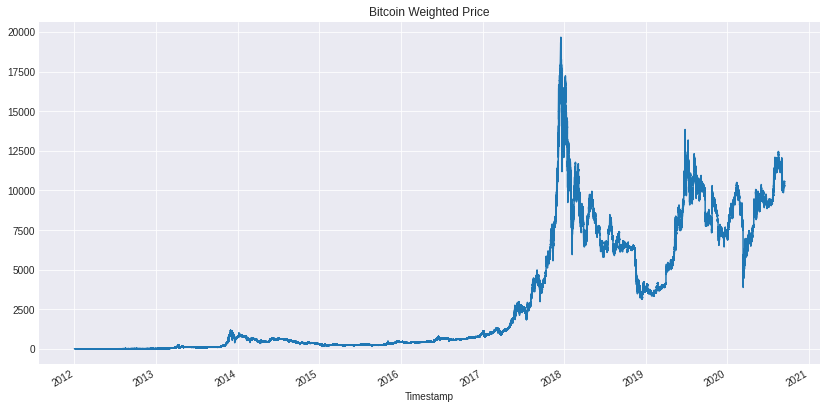

In [9]:
bitstamp.set_index("Timestamp").Weighted_Price.plot(figsize=(14,7), title="Bitcoin Weighted Price")

<a id="section-two"></a>
# Handling Missing Values in Time-series Data

It is very common for a time-series data to have missing data. The first step is to detect the count/percentage of missing values in every column of the dataset. This will give an idea about the distribution of missing values. Let's check this in our dataset:

In [10]:
#calculating missing values in the dataset

missing_values = bitstamp.isnull().sum()
missing_per = (missing_values/bitstamp.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
Timestamp,0,0.000000
Open,1241716,27.157616
High,1241716,27.157616
Low,1241716,27.157616
Close,1241716,27.157616
Volume_(BTC),1241716,27.157616
Volume_(Currency),1241716,27.157616
Weighted_Price,1241716,27.157616


# Imputations Techniques for non Time Series Problems

Imputation refers to replacing missing data with substituted values.There are a lot of ways in which the missing values can be imputed depending upon the nature of the problem and data. Dependng upon the nature of the problem, imputation techniques can be broadly they can be classified as follows:

**Basic Imputation Techniques**
* 'ffill' or 'pad' - Replace NaNs with last observed value
* 'bfill' or 'backfill' - Replace NaNs with next observed value
*  Linear interpolation method

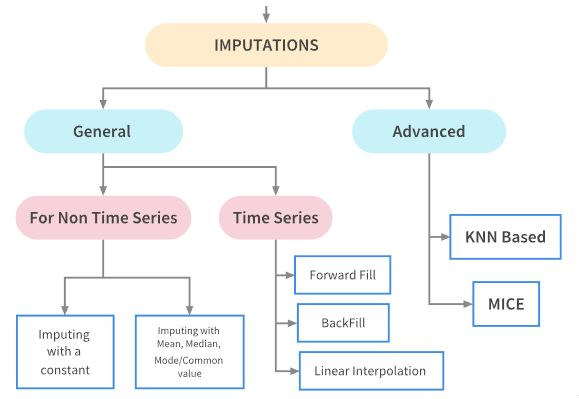

Let's sense check above stated 3 techniques on a subset to compare the output:

In [11]:
#testing missing value methods on a subset

pd.set_option('display.max_rows', 1500)

a = bitstamp.set_index('Timestamp')

a = a['2019-11-01 00:15:00':'2019-11-01 02:24:00']

a['ffill'] = a['Weighted_Price'].fillna(method='ffill') # Imputation using ffill/pad
a['bfill'] = a['Weighted_Price'].fillna(method='bfill') # Imputation using bfill/pad
a['interp'] = a['Weighted_Price'].interpolate()         # Imputation using interpolation

a

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,ffill,bfill,interp
Timestamp,,,,,,,,,,
2019-11-01 00:15:00,9132.07,9132.07,9131.28,9132.06,2.790997,25486.770016,9131.781301,9131.781301,9131.781301,9131.781301
2019-11-01 00:16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9131.781301,9124.030314,9127.905808
2019-11-01 00:17:00,9133.46,9133.46,9124.00,9124.00,4.615205,42109.267498,9124.030314,9124.030314,9124.030314,9124.030314
2019-11-01 00:18:00,9127.51,9127.91,9123.83,9123.83,0.115982,1058.256390,9124.345653,9124.345653,9124.345653,9124.345653
2019-11-01 00:19:00,9123.68,9127.88,9119.24,9119.24,0.844218,7702.491217,9123.816937,9123.816937,9123.816937,9123.816937
2019-11-01 00:20:00,9126.28,9127.91,9125.71,9125.71,0.041975,383.073893,9126.269690,9126.269690,9126.269690,9126.269690
2019-11-01 00:21:00,9126.87,9127.90,9112.05,9118.12,2.015965,18385.049732,9119.727734,9119.727734,9119.727734,9119.727734
2019-11-01 00:22:00,9117.64,9131.03,9116.99,9131.03,9.102945,83046.782409,9123.067760,9123.067760,9123.067760,9123.067760
2019-11-01 00:23:00,9131.54,9134.49,9119.13,9128.74,2.181277,19900.076044,9123.129222,9123.129222,9123.129222,9123.129222


**Imputation using Linear Interpolation method**

Time series data has a lot of variations against time. Hence, imputing using backfill and forward fill isn't the best possible solution to address the missing value problem. A more apt alternative would be to use interpolation methods, where the values are filled with incrementing or decrementing values.

[Linear interpolation](https://www.lexjansen.com/nesug/nesug01/ps/ps8026.pdf) is an imputation technique that assumes a linear relationship between data points and utilises non-missing values from adjacent data points to compute a value for a missing data point.

Refer to the official documentation for a complete list of interpolation strategies [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)

In our dataset, we will be performing Linear interpolation on the missing value columns.

In [12]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()

    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()

    print(df.head())
    print(df.isnull().sum())

In [13]:
fill_missing(bitstamp)

            Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0 2011-12-31 07:52:00  4.39  4.39  4.39   4.39      0.455581   
1 2011-12-31 07:53:00  4.39  4.39  4.39   4.39      0.555046   
2 2011-12-31 07:54:00  4.39  4.39  4.39   4.39      0.654511   
3 2011-12-31 07:55:00  4.39  4.39  4.39   4.39      0.753977   
4 2011-12-31 07:56:00  4.39  4.39  4.39   4.39      0.853442   

   Volume_(Currency)  Weighted_Price  
0           2.000000            4.39  
1           2.436653            4.39  
2           2.873305            4.39  
3           3.309958            4.39  
4           3.746611            4.39  
Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


No Null values in the final output. Now we will move to **Exploratory Data Analysis**.

First, we will create a copy of the dataset as in the next step we will be setting index as our Timestamp column. Its main advatange is to be able to query the datset fast and also helps in quering and filtering the dataset. Also, a lot of plots require our dataset to be indexed.

In [14]:
#created a copy 
bitstamp_non_indexed = bitstamp.copy()

In [15]:
bitstamp = bitstamp.set_index('Timestamp')
bitstamp.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39


In [16]:
bitstamp.shape

(4572257, 7)

<a id="section-three"></a>

# Exploratory Data Analysis

**Visualizing the weighted price using markers**

When working with time-series data, a lot can be revealed through visualizing it.
It is possible to add markers in the plot to help emphasize the specific observations or specific events in the time series.

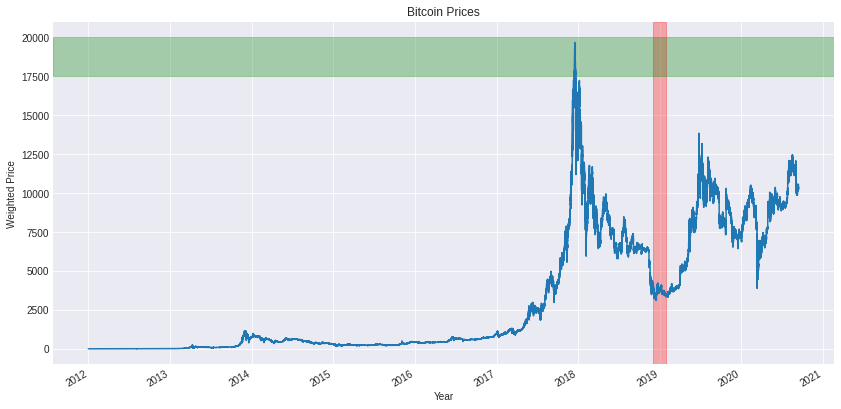

In [17]:
ax = bitstamp['Weighted_Price'].plot(title='Bitcoin Prices', grid=True, figsize=(14,7))
ax.set_xlabel('Year')
ax.set_ylabel('Weighted Price')

ax.axvspan('2018-12-01','2019-01-31',color='red', alpha=0.3)
ax.axhspan(17500,20000, color='green',alpha=0.3)

Text(0, 0.5, 'Weighted_Price')

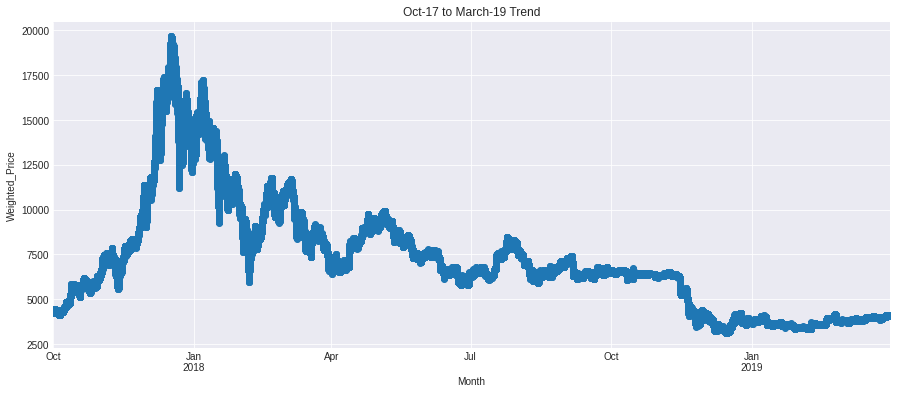

In [18]:
#Zooming in

ax = bitstamp.loc['2017-10':'2019-03','Weighted_Price'].plot(marker='o', linestyle='-',figsize=(15,6), title="Oct-17 to March-19 Trend", grid=True)
ax.set_xlabel('Month')
ax.set_ylabel('Weighted_Price')

There has been a increase in Bitcoin's weighted price except a slump in late 2018 and early 2019. Also, we can  observe a spike in weighted price in December 2017. We shall use Pandas to investigate it further in the coming sections.

# Visualising using KDEs

Summarizing the data with Density plots to see where the mass of the data is located.

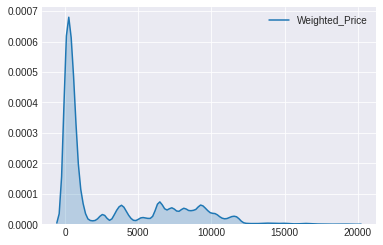

In [19]:
sns.kdeplot(bitstamp['Weighted_Price'], shade=True)

So there is a downward trend in stock prices from Dec-17 onwards till March 2019. We will investigate it further by investigation and with some findings during that period.

<a id="subsection-two"></a>

# Visualizing using Lag Plots

Lag plot are used to observe the autocorrelation. These are crucial when we try to correct the trend and stationarity and we have to use smoothing functions. Lag plot helps us to understand the data better.

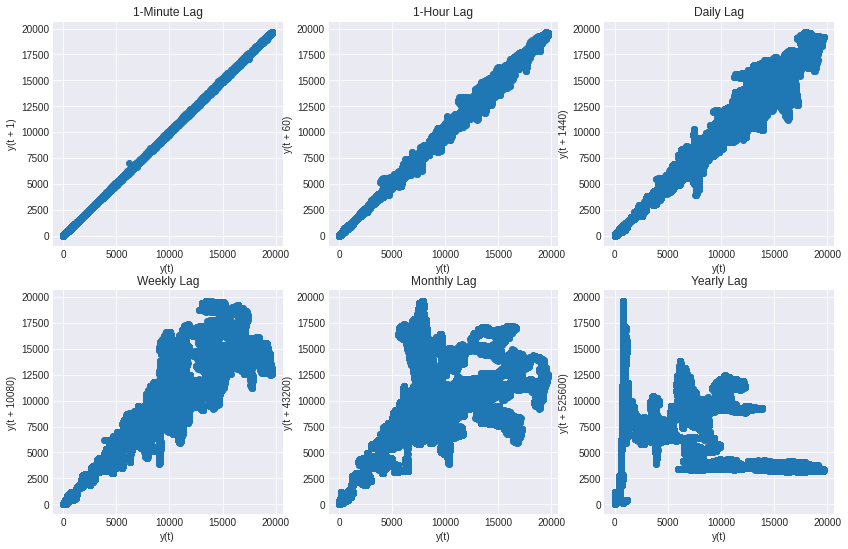

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 14

plt.subplot(3,3,1)
pd.plotting.lag_plot(bitstamp['Weighted_Price'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(bitstamp['Weighted_Price'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(bitstamp['Weighted_Price'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(bitstamp['Weighted_Price'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(bitstamp['Weighted_Price'], lag=43200) #month lag
plt.title('Monthly Lag')

plt.subplot(3,3,6)
pd.plotting.lag_plot(bitstamp['Weighted_Price'], lag=525600) #yearly lag
plt.title('Yearly Lag')

plt.legend()
plt.show()

We can see that there is a positive correlation for minute, hour and daily lag plots. We observe absolutely no correlation for month lag plots.

It makes sense to re-sample our data atmost at the Daily level, thereby preserving the autocorrelation as well. 

<a id="subsection-three"></a>

# Time resampling

Examining stock price data for every single day isn’t of much use to financial institutions, who are more interested in spotting market trends. To make it easier, we use a process called time resampling to aggregate data into a defined time period, such as by month or by quarter. Institutions can then see an overview of stock prices and make decisions according to these trends.

The pandas library has a .resample() function which resamples such time series data. The resample method in pandas is similar to its groupby method as it is essentially grouping according to a certain time span. The resample() function looks like this:

In [21]:
hourly_data = bitstamp.resample('1H').mean()
hourly_data = hourly_data.reset_index()

hourly_data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:00:00,4.39,4.39,4.39,4.39,0.803709,3.528285,4.39
1,2011-12-31 08:00:00,4.39,4.39,4.39,4.39,4.185530,18.374477,4.39
2,2011-12-31 09:00:00,4.39,4.39,4.39,4.39,10.153449,44.573640,4.39
3,2011-12-31 10:00:00,4.39,4.39,4.39,4.39,16.121368,70.772803,4.39
4,2011-12-31 11:00:00,4.39,4.39,4.39,4.39,22.089286,96.971967,4.39


**To summarize what happened above:**

* data.resample() is used to resample the stock data.
* The ‘1H’ stands for hourly frequency, and denotes the offset values by which we want to resample the data.
* mean() indicates that we want the average stock price during this period.

The offset values list can be found in the pandas [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

In [22]:
bitstamp_daily = bitstamp.resample("24H").mean() #daily resampling

# Plotting using Plotly

Plotly allows us to make interactve charts which are pretty useful in financial analysis. 

* The **range-sliders** can be used to zoom-in and zoom-out.
* The **range-selectors** can be used to select the range.

In [23]:
import plotly.express as px

bitstamp_daily.reset_index(inplace=True)
fig = px.line(bitstamp_daily, x='Timestamp', y='Weighted_Price', title='Weighted Price with Range Slider and Selectors')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(step="all")
            
        ])
    )
)
fig.show()

# Simple Candlestick Graph

In [24]:
plot_ = bitstamp_daily.set_index("Timestamp")["2017-12"]

In [25]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Candlestick(x= plot_.index,
                    open=plot_['Open'],
                    high=plot_['High'],
                    low=plot_['Low'],
                    close=plot_['Close']))
fig.show()

<a id="section-four"></a>
# Time Series Decomposition & Statistical Tests

We can decompose a time series into trend, seasonal amd remainder components, as mentioned in the earlier section. The series can be decomposed as an additive or multiplicative combination of the base level, trend, seasonal index and the residual.
The seasonal_decompose in statsmodels is used to implements the decomposition.

We will then perform some statistical tests like [KPSS](http://en.wikipedia.org/wiki/KPSS_test) and [Augmented Dickey–Fuller](http://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) tests to check stationarity. 

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Let's ensure there are no missing values before you perform statistical tests.

In [27]:
fill_missing(bitstamp_daily)

   Timestamp      Open      High       Low     Close  Volume_(BTC)  \
0 2011-12-31  4.476415  4.478946  4.476415  4.478946     17.940426   
1 2012-01-01  4.765576  4.765576  4.765576  4.765576      6.790640   
2 2012-01-02  5.006549  5.006549  5.006549  5.006549     15.183373   
3 2012-01-03  5.206530  5.206530  5.206530  5.206530      7.917041   
4 2012-01-04  5.202511  5.241699  5.202511  5.241699     13.659736   

   Volume_(Currency)  Weighted_Price  
0          79.495594        4.477370  
1          32.971105        4.765576  
2          75.932706        5.006549  
3          40.795994        5.206530  
4          72.860096        5.216680  
Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


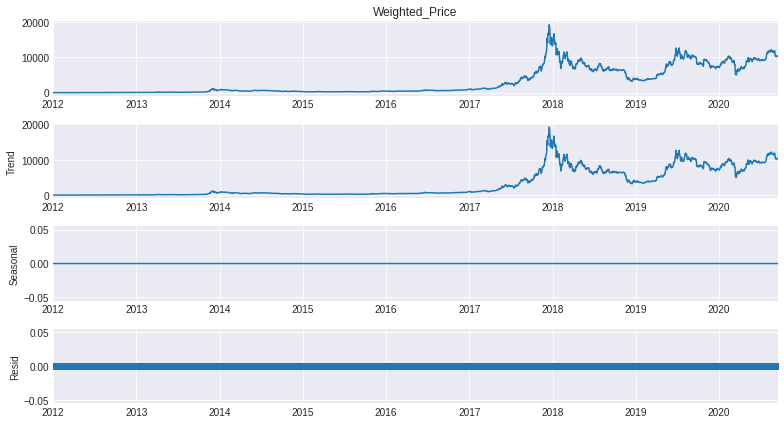

In [28]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 6
series = bitstamp_daily.set_index("Timestamp").Weighted_Price
result = seasonal_decompose(series, model='additive',period=1)
fig=result.plot()
plt.show()

Post time series decomposition we don't observe any seasonality. Also, there is no constant mean, variance and covariance, hence the series is **Non Stationary.** 
We will perform statistical tests like KPSS and ADF to confirm our understanding.

But first, let's plot ACF and PACF graphs.

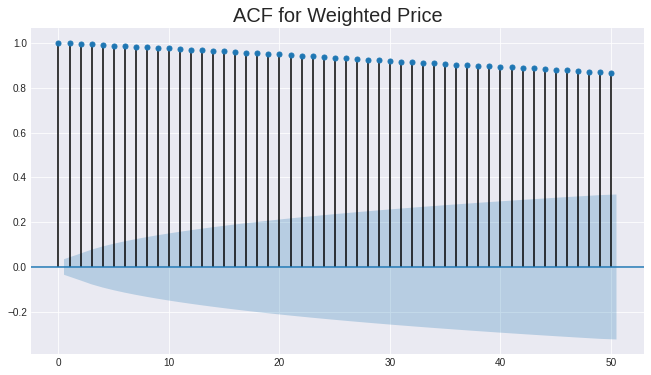

In [29]:
acf = plot_acf(series, lags=50, alpha=0.05)
plt.title("ACF for Weighted Price", size=20)
plt.show()

The above graph shows that effect barely detoriate over time, so past values affect the present ones. The more lags we include, the better our model will fit the dataset, now the risk is coefficients might predict the dataset too well, cause an overfitting.
In our model, we always try to include only those lags which have a direct effect on our present value. Hence, let's try PACF.

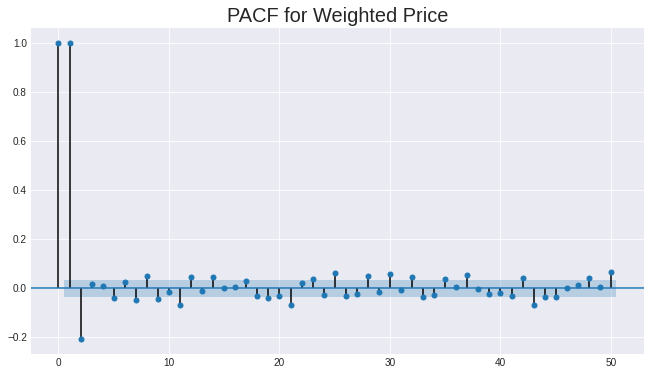

In [30]:
plot_pacf(series, lags=50, alpha=0.05, method='ols')
plt.title("PACF for Weighted Price", size=20)
plt.show()

Coefficients values for lag>5 are statistically not significant and their impact on the model is minimal, except a few spikes at 8,11,22 and beyond.

<a id="subsection-four"></a>
# KPSS Test

The KPSS test, short for, Kwiatkowski-Phillips-Schmidt-Shin (KPSS), is a type of Unit root test that tests for the stationarity of a given series around a deterministic trend.

Here, the null hypothesis is that the series is **stationary**.

That is, if p-value is < signif level (say 0.05), then the series is non-stationary and vice versa.

In [31]:
stats, p, lags, critical_values = kpss(series, 'ct')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning:

p-value is smaller than the indicated p-value



In [32]:
print(f'Test Statistics : {stats}')
print(f'p-value : {p}')
print(f'Critical Values : {critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test Statistics : 0.9719743430417114
p-value : 0.01
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


# Interpreting KPSS test results

The output of the KPSS test contains 4 things:

* The KPSS statistic
* p-value
* Number of lags used by the test
* Critical values

The **p-value** reported by the test is the probability score based on which you can decide whether to reject the null hypothesis or not. If the p-value is less than a predefined alpha level (typically 0.05), we reject the null hypothesis.

The **KPSS statistic** is the actual test statistic that is computed while performing the test.

The number of **lags** reported is the number of lags of the series that was actually used by the model equation of the kpss test.

In order to reject the null hypothesis, the test statistic should be greater than the provided critical values. If it is in fact higher than the target critical value, then that should automatically reflect in a low p-value.
That is, if the p-value is less than 0.05, the kpss statistic will be greater than the 5% critical value.

<a id="subsection-five"></a>
# ADF Test

The only difference here is the Null hypothesis which is just opposite of KPSS.

The null hypothesis of the test is the presence of **unit root**, that is, the series is **non-stationary**.

In [33]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)
    
    if p > 0.05:
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [34]:
adf_test(series)

Results of Dickey-Fuller Test:
Test Statistic                   -1.257922
p-value                           0.648197
#Lags Used                       29.000000
Number of Observations Used    3151.000000
Critical Value (1%)              -3.432427
Critical Value (5%)              -2.862458
Critical Value (10%)             -2.567259
dtype: float64
Series is Stationary


# Conclusion


KPSS says series is not stationary and ADF says series is stationary. It means series is **difference stationary**, we will use **differencing** to make series stationary.

<a id="section-five"></a>
# Feature Extraction

# Rolling windows

Time series data can be noisy due to high fluctuations in the market. As a result, it becomes difficult to gauge a trend or pattern in the data. 

As we’re looking at daily data, there’s quite a bit of noise present. It would be nice if we could average this out by a week, which is where a rolling mean comes in. 

A rolling mean, or moving average, is a transformation method which helps average out noise from data. It works by simply splitting and aggregating the data into windows according to function, such as mean(), median(), count(), etc. For this example, we’ll use a rolling mean for 3, 7 and 30 days.

In [35]:
df = bitstamp_daily.set_index("Timestamp")

In [36]:
df.reset_index(drop=False, inplace=True)

lag_features = ["Open", "High", "Low", "Close","Volume_(BTC)"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index()
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index()
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()

df_std_3d = df_rolled_3d.std().shift(1).reset_index()
df_std_7d = df_rolled_7d.std().shift(1).reset_index()
df_std_30d = df_rolled_30d.std().shift(1).reset_index()

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Timestamp", drop=False, inplace=True)
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Open_mean_lag3,Open_mean_lag7,...,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,Volume_(BTC)_mean_lag3,Volume_(BTC)_mean_lag7,Volume_(BTC)_mean_lag30,Volume_(BTC)_std_lag3,Volume_(BTC)_std_lag7,Volume_(BTC)_std_lag30
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-31,2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370,3070.007835,3063.529743,...,3023.843754,70.836828,118.491226,269.127206,9.811957,9.817411,9.825918,3.522567,4.288554,5.298253
2012-01-01,2012-01-01,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576,4.476415,4.476415,...,4.478946,70.836828,118.491226,269.127206,17.940426,17.940426,17.940426,3.522567,4.288554,5.298253
2012-01-02,2012-01-02,5.006549,5.006549,5.006549,5.006549,15.183373,75.932706,5.006549,4.620996,4.620996,...,4.622261,0.202678,0.202678,0.202678,12.365533,12.365533,12.365533,7.884089,7.884089,7.884089
2012-01-03,2012-01-03,5.206530,5.206530,5.206530,5.206530,7.917041,40.795994,5.206530,4.749513,4.749513,...,4.750357,0.264130,0.264130,0.264130,13.304813,13.304813,13.304813,5.807423,5.807423,5.807423
2012-01-04,2012-01-04,5.202511,5.241699,5.202511,5.241699,13.659736,72.860096,5.216680,4.992885,4.863768,...,4.864400,0.220794,0.313900,0.313900,9.963685,11.957870,11.957870,4.555332,5.453543,5.453543


**Benefits :**

So, what are the key benefits of calculating a moving average or using this rolling mean method? Our data becomes a lot less noisy and more reflective of the trend than the data itself.

Let's extract time and date features from the Date column.

In [37]:
df["month"] = df.Timestamp.dt.month
df["week"] = df.Timestamp.dt.week
df["day"] = df.Timestamp.dt.day
df["day_of_week"] = df.Timestamp.dt.dayofweek
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Open_mean_lag3,Open_mean_lag7,...,Volume_(BTC)_mean_lag3,Volume_(BTC)_mean_lag7,Volume_(BTC)_mean_lag30,Volume_(BTC)_std_lag3,Volume_(BTC)_std_lag7,Volume_(BTC)_std_lag30,month,week,day,day_of_week
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-31,2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370,3070.007835,3063.529743,...,9.811957,9.817411,9.825918,3.522567,4.288554,5.298253,12,52,31,5
2012-01-01,2012-01-01,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576,4.476415,4.476415,...,17.940426,17.940426,17.940426,3.522567,4.288554,5.298253,1,52,1,6
2012-01-02,2012-01-02,5.006549,5.006549,5.006549,5.006549,15.183373,75.932706,5.006549,4.620996,4.620996,...,12.365533,12.365533,12.365533,7.884089,7.884089,7.884089,1,1,2,0
2012-01-03,2012-01-03,5.206530,5.206530,5.206530,5.206530,7.917041,40.795994,5.206530,4.749513,4.749513,...,13.304813,13.304813,13.304813,5.807423,5.807423,5.807423,1,1,3,1
2012-01-04,2012-01-04,5.202511,5.241699,5.202511,5.241699,13.659736,72.860096,5.216680,4.992885,4.863768,...,9.963685,11.957870,11.957870,4.555332,5.453543,5.453543,1,1,4,2


<a id="section-six"></a>
# Model Building

# Important Note on Cross Validation

To measure the performance of our forecasting model, We typically want to split the time series into a training period and a validation period. This is called fixed partitioning. 

* If the time series has some seasonality, you generally want to ensure that each period contains a whole number of seasons. For example, one year, or two years, or three years, if the time series has a yearly seasonality. 
You generally don't want one year and a half, or else some months will be represented more than others. 
 
* We'll train our model on the training period, we'll evaluate it on the validation period. Here's where you can experiment to find the right architecture for training. And work on it and your hyper parameters, until you get the desired performance, measured using the validation set. Often, once you've done that, you can retrain using both the training and validation data.And then test on the test(or forecast) period to see if your model will perform just as well.
 
* And if it does, then you could take the unusual step of retraining again, using also the test data. But why would you do that? Well, it's because the test data is the closest data you have to the current point in time. And as such it's often the strongest signal in determining future values. If your model is not trained using that data, too, then it may not be optimal.

Here, we we will opt for a ***hold-out based validation***. 

Hold-out is used very frequently with time-series data. In this case, we will select all the data for 2020 as a hold-out and train our model on all the data from 2012 to 2019. 


In [38]:
df_train = df[df.Timestamp < "2020"]
df_valid = df[df.Timestamp >= "2020"]

print('train shape :', df_train.shape)
print('validation shape :', df_valid.shape)

train shape : (2923, 42)
validation shape : (258, 42)


<a id="subsection-six"></a>
# ARIMA Model

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

* **AR: Autoregression** A model that uses the dependent relationship between an observation and some number of lagged observations.
* **I: Integrated** The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* **MA: Moving Average** A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specic ARIMA model being used.

* **p**: The number of lag observations included in the model, also called the lag order.
* **d**: The number of times that the raw observations are differenced, also called the degree of dfferencing.
* **q**: The size of the moving average window, also called the order of moving average.

Happy further reading [here](http://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

In [39]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 4.6 MB/s 
     |████████████████████████████████| 14.8 MB 42.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.3.0 requires numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.5 which is incompatible.
osmnx 0.15.1 requires geopandas>=0.7, but you'll have geopandas 0.6.3 which is incompatible.
kornia 0.4.0 requires torch<1.7.0,>=1.6.0, but you'll have torch 1.5.1 which is incompatible.
kmeans-smote 0.1.2 requires imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.7.0 which is incompatible.
kmeans-smote 0.1.2 requires nu

In [40]:
import pmdarima as pm

In [41]:
exogenous_features = ['Open_mean_lag3',
       'Open_mean_lag7', 'Open_mean_lag30', 'Open_std_lag3', 'Open_std_lag7',
       'Open_std_lag30', 'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30',
       'High_std_lag3', 'High_std_lag7', 'High_std_lag30', 'Low_mean_lag3',
       'Low_mean_lag7', 'Low_mean_lag30', 'Low_std_lag3', 'Low_std_lag7',
       'Low_std_lag30', 'Close_mean_lag3', 'Close_mean_lag7',
       'Close_mean_lag30', 'Close_std_lag3', 'Close_std_lag7',
       'Close_std_lag30', 'Volume_(BTC)_mean_lag3', 'Volume_(BTC)_mean_lag7',
       'Volume_(BTC)_mean_lag30', 'Volume_(BTC)_std_lag3',
       'Volume_(BTC)_std_lag7', 'Volume_(BTC)_std_lag30', 'month', 'week',
       'day', 'day_of_week']

In [42]:
model = pm.auto_arima(df_train.Weighted_Price, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Weighted_Price, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=38878.887, Time=26.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=40085.697, Time=4.30 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39088.240, Time=14.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=39256.270, Time=20.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=40099.503, Time=20.84 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=38867.865, Time=24.60 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=38904.028, Time=23.86 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=39045.065, Time=22.26 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=38873.369, Time=8.89 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=38871.966, Time=23.90 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=39030.574, Time=25.63 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=38874.589, Time=27.63 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=38865.940, Time=24.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=38902.277, Time=23.71 sec
 ARIMA(

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Bitcoin Price')

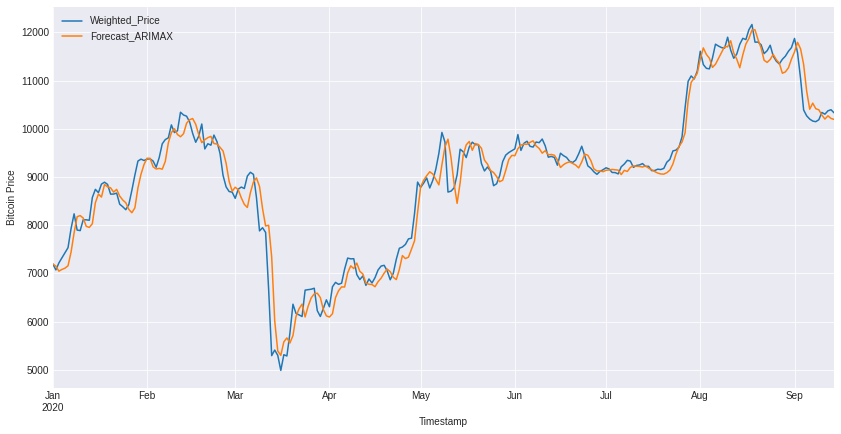

In [43]:
df_valid[["Weighted_Price", "Forecast_ARIMAX"]].plot(figsize=(14, 7))
plt.ylabel('Bitcoin Price')

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.Weighted_Price, df_valid.Forecast_ARIMAX)))

print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.Weighted_Price, df_valid.Forecast_ARIMAX))

print("\nR2 of Auto ARIMAX:", r2_score(df_valid.Weighted_Price, df_valid.Forecast_ARIMAX))


RMSE of Auto ARIMAX: 322.18643330459946

MAE of Auto ARIMAX: 226.99840002996618

R2 of Auto ARIMAX: 0.9572721223087073


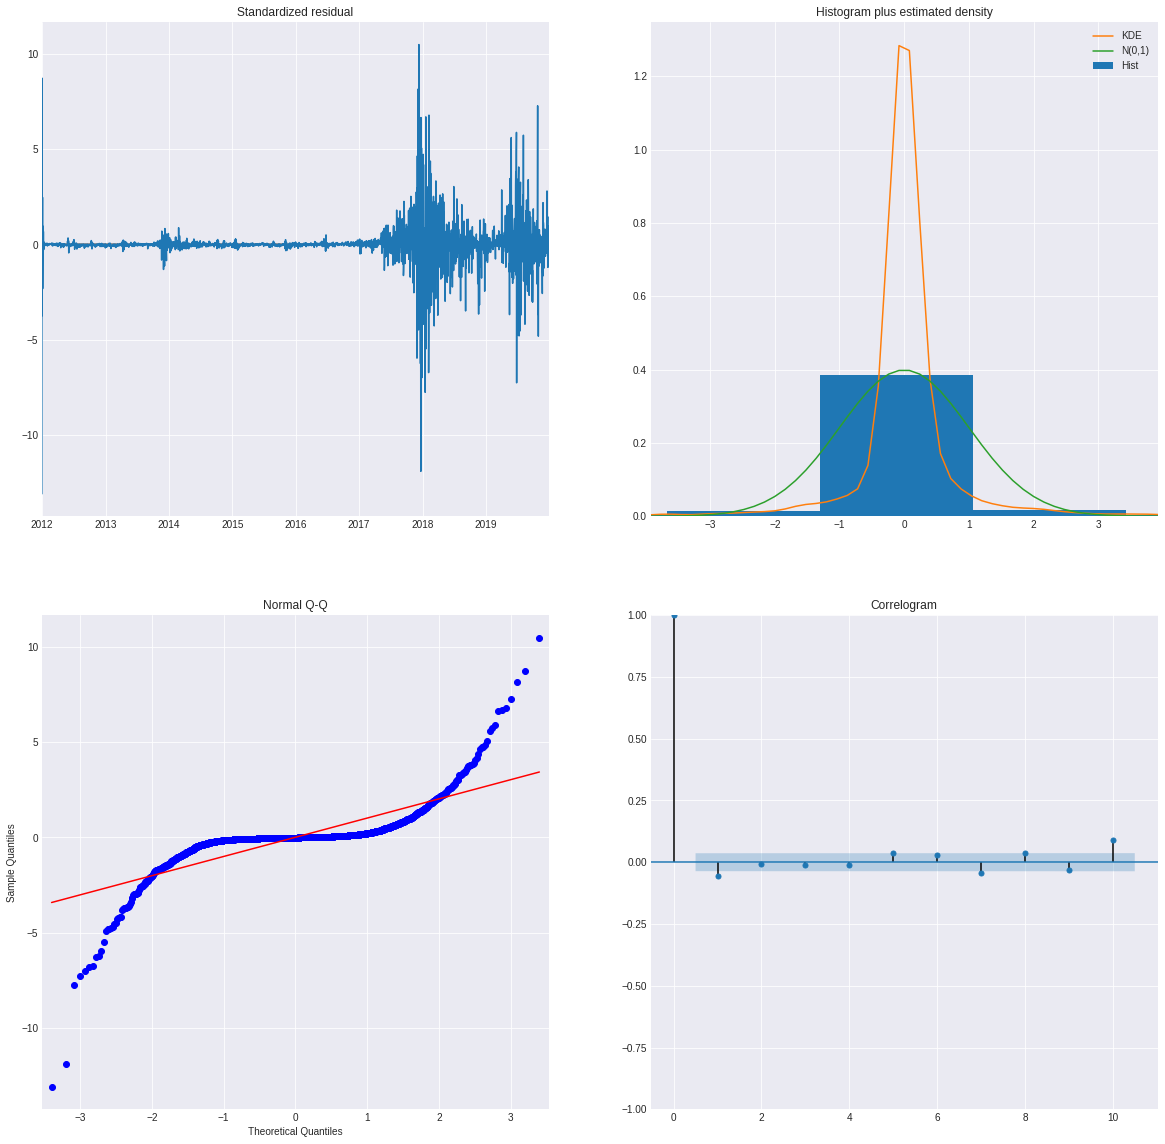

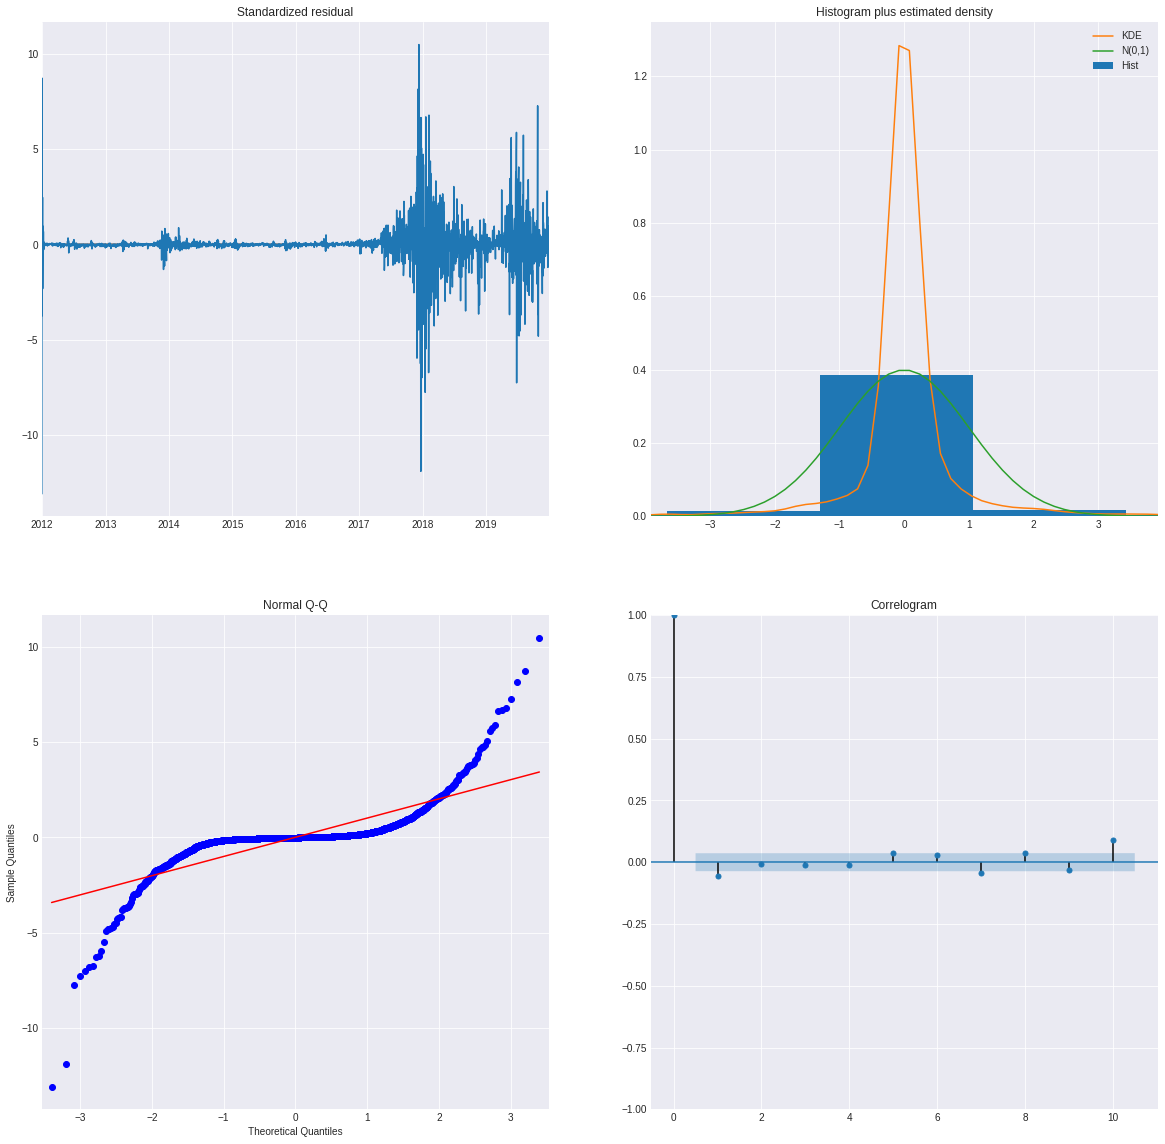

In [45]:
model.plot_diagnostics(figsize=(20, 20))

The Auto ARIMAX model seems to do a fairly good job in predicting the bitcoin price given data till the previous day. Can other models beat this benchmark?

<a id="subsection-seven"></a>
# Facebook Prophet

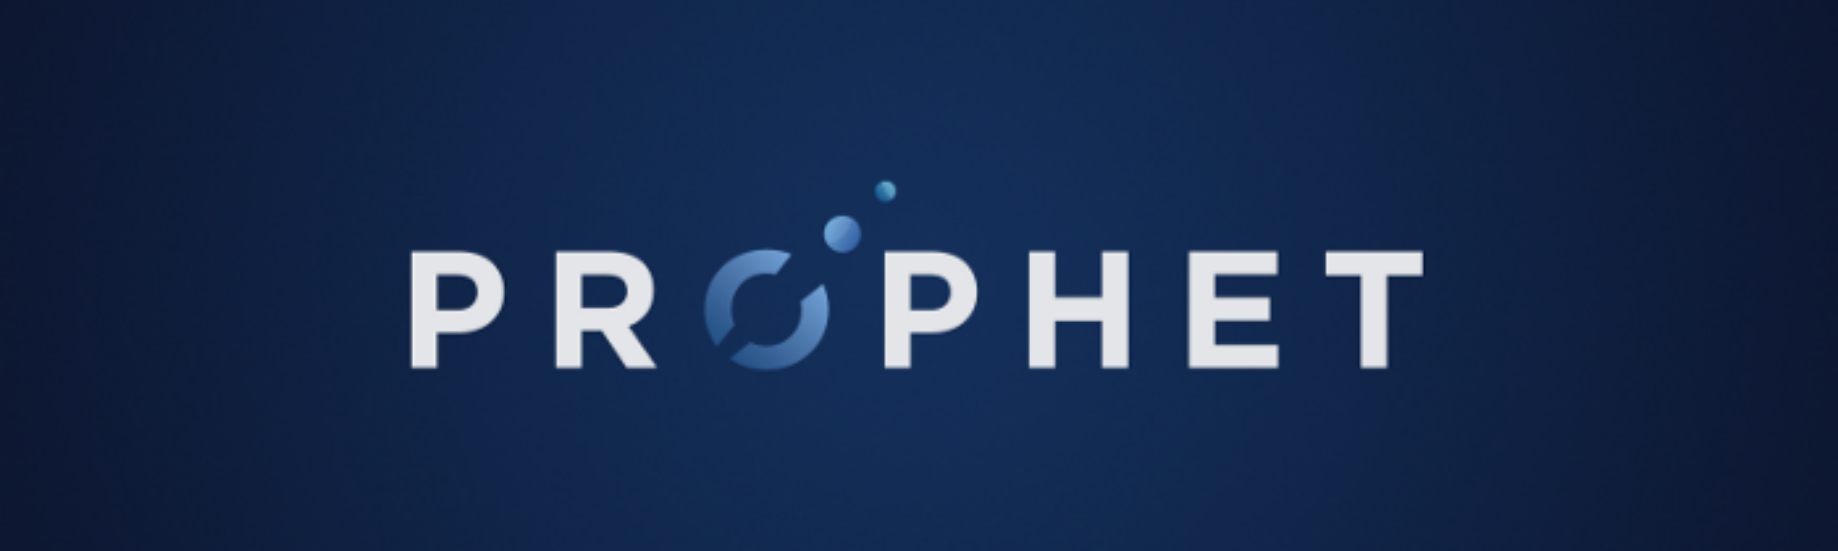

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. 

# How does Prophet work?
The procedure makes use of a decomposable time series model with three main model components: trend, seasonality, and holidays.

**y(t) = g(t) + s(t) + h(t) + e(t)**

- **g(t)** trend models non-periodic changes; linear or logistic
- **s(t)** seasonality represents periodic changes; i.e. weekly, monthly, yearly
- **h(t)** ties in effects of holidays; on potentially irregular schedules ≥ 1 day(s)

The error term e(t) represents any idiosyncratic changes which are not accommodated by the model; later we will make the parametric assumption that e(t) is normally distributed. Facebook paper can be referenced for more details [here](http://peerj.com/preprints/3190.pdf#section.1)

Let's start modelling!

In [46]:
# Load FB Prophet
from fbprophet import Prophet

In [47]:
# Resampling originial data to day level and forward fill the missing values
daily_data = bitstamp.resample("24H").mean() #daily resampling
fill_missing(daily_data)

                Open      High       Low     Close  Volume_(BTC)  \
Timestamp                                                          
2011-12-31  4.476415  4.478946  4.476415  4.478946     17.940426   
2012-01-01  4.765576  4.765576  4.765576  4.765576      6.790640   
2012-01-02  5.006549  5.006549  5.006549  5.006549     15.183373   
2012-01-03  5.206530  5.206530  5.206530  5.206530      7.917041   
2012-01-04  5.202511  5.241699  5.202511  5.241699     13.659736   

            Volume_(Currency)  Weighted_Price  
Timestamp                                      
2011-12-31          79.495594        4.477370  
2012-01-01          32.971105        4.765576  
2012-01-02          75.932706        5.006549  
2012-01-03          40.795994        5.206530  
2012-01-04          72.860096        5.216680  
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


In [48]:
# Renaming the column names accroding to Prophet's requirements

daily_data_fb = daily_data.reset_index()[['Timestamp','Weighted_Price']].rename({'Timestamp':'ds','Weighted_Price':'y'}, axis=1)
daily_data_fb.head()

,ds,y
0,2011-12-31,4.477370
1,2012-01-01,4.765576
2,2012-01-02,5.006549
3,2012-01-03,5.206530
4,2012-01-04,5.216680


In [49]:
split_date = "2020-01-01"
train_filt = daily_data_fb['ds'] <= split_date
test_filt = daily_data_fb['ds'] > split_date

train_fb = daily_data_fb[train_filt]
test_fb = daily_data_fb[test_filt]

In [50]:
print("train data shape :", train_fb.shape)
print("test data shape :", test_fb.shape)

train data shape : (2924, 2)
test data shape : (257, 2)


In [51]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Timestamp", "Weighted_Price"] + exogenous_features].rename(columns={"Timestamp": "ds", "Weighted_Price": "y"}))

forecast = model_fbp.predict(df_valid[["Timestamp", "Weighted_Price"] + exogenous_features].rename(columns={"Timestamp": "ds"}))
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Close_mean_lag3,Close_mean_lag3_lower,Close_mean_lag3_upper,Close_mean_lag30,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,2678.205982,7079.919541,7702.610531,2678.205982,2678.205982,4485.913784,4485.913784,4485.913784,4.756947,...,0.386279,0.386279,0.386279,-46.274614,-46.274614,-46.274614,0.0,0.0,0.0,7392.305314
1,2020-01-02,2678.285233,6991.233348,7621.432142,2678.285233,2678.285233,4438.764788,4438.764788,4438.764788,4.753125,...,-9.389695,-9.389695,-9.389695,-64.275029,-64.275029,-64.275029,0.0,0.0,0.0,7323.098165
2,2020-01-03,2678.364483,6905.001112,7512.554608,2678.364483,2678.364483,4367.641366,4367.641366,4367.641366,4.744881,...,-8.935748,-8.935748,-8.935748,-81.626555,-81.626555,-81.626555,0.0,0.0,0.0,7193.657723
3,2020-01-04,2678.443734,6926.035887,7547.734707,2678.443734,2678.443734,4373.594465,4373.594465,4373.594465,4.742928,...,13.927711,13.927711,13.927711,-98.212190,-98.212190,-98.212190,0.0,0.0,0.0,7247.185874
4,2020-01-05,2678.522984,6934.778148,7545.853051,2678.522984,2678.522984,4413.382673,4413.382673,4413.382673,4.742713,...,0.966174,0.966174,0.966174,-113.928453,-113.928453,-113.928453,0.0,0.0,0.0,7233.424124


**Narrative**
* **yhat** : the predicted forecast
* **yhat_lower** : the lower border of the prediction
* **yhat_upper**: the upper border of the prediction

In [52]:
df_valid["Forecast_Prophet"] = forecast.yhat.values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



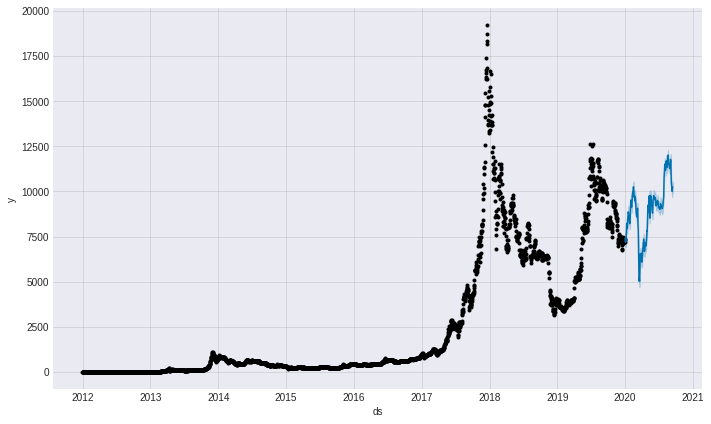

In [53]:
# Plot Our Predictions
fig1 = model_fbp.plot(forecast)

**Narrative**

* **Black dots** : the actual data points in our dataset.
* **Deep blue line** : the predicted forecast/the predicted values
* **Light blue line** : the boundaries

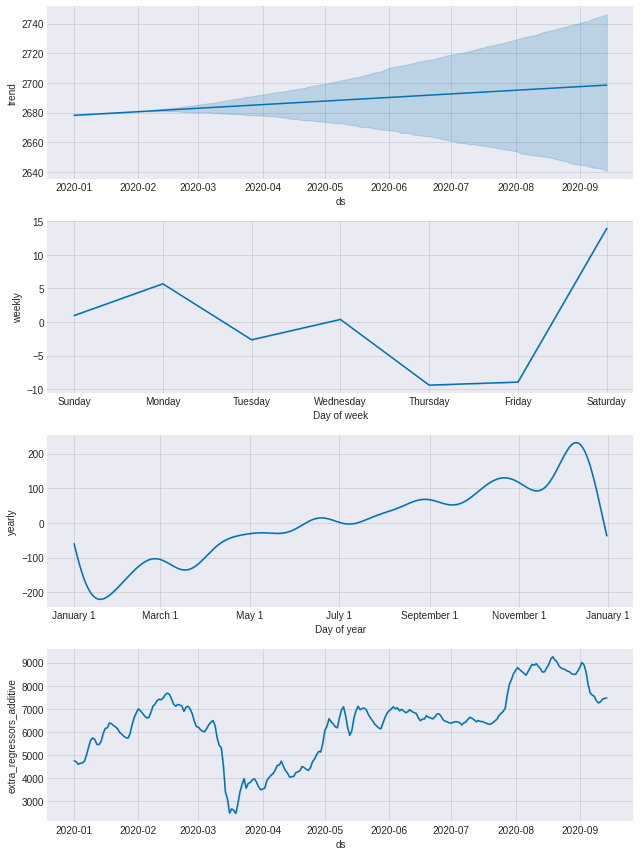

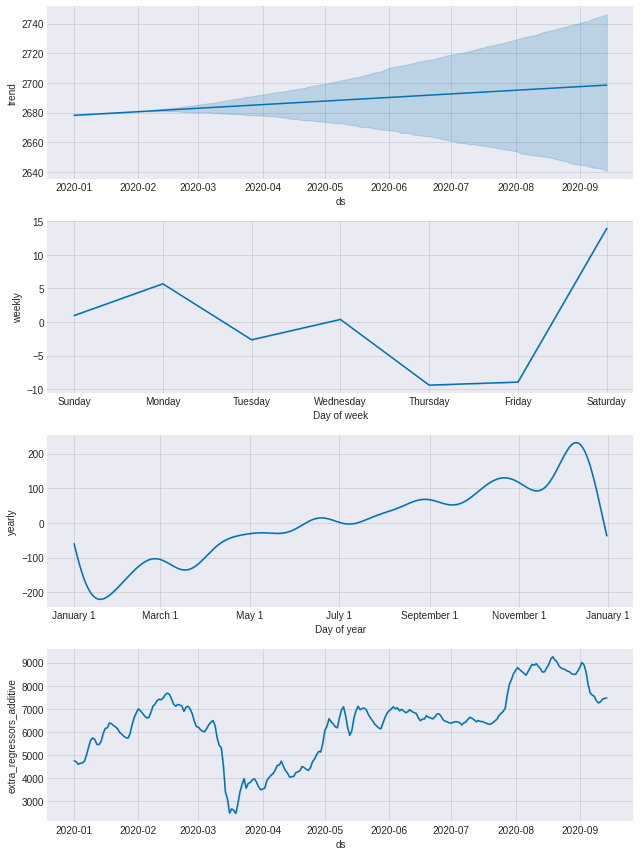

In [54]:
model_fbp.plot_components(forecast)

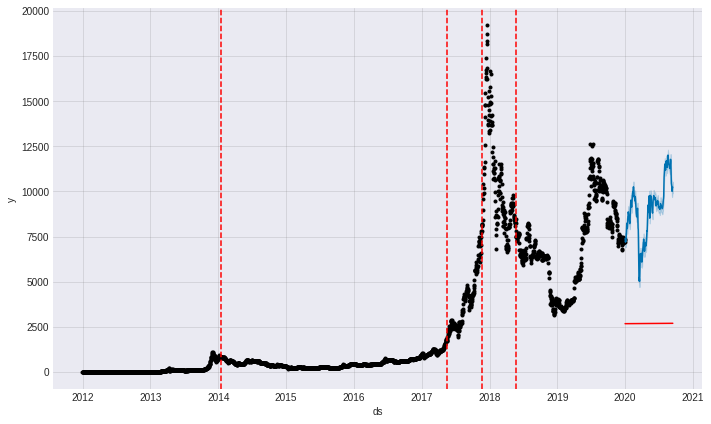

In [55]:
# Plotting changepoints
from fbprophet.plot import add_changepoints_to_plot
fig = model_fbp.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model_fbp, forecast)

Text(0, 0.5, 'Bitcoin Price')

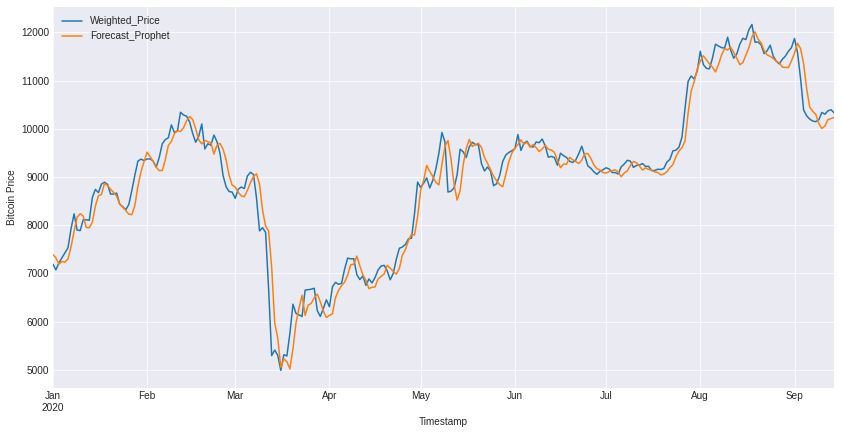

In [56]:
df_valid[["Weighted_Price", "Forecast_Prophet"]].plot(figsize=(14, 7))
plt.ylabel('Bitcoin Price')

In [57]:
test_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_Prophet'])
test_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_Prophet']))
test_r2 = r2_score(df_valid['Weighted_Price'], df_valid['Forecast_Prophet'])
print(f" Prophet's MAE : {test_mae}")
print(f"Prophet's RMSE : {test_rmse}")
print(f"Prophet's R2 : {test_r2}")

 Prophet's MAE : 229.59667095230242
Prophet's RMSE : 323.0097924038709
Prophet's R2 : 0.9570534579850434


In [58]:
# #Keeping only relevant columns
# forecast_df = forecast[['ds','yhat','yhat_lower','yhat_upper' ]]
# forecast_df

# # Plotting the predicted values -> yhat
# forecast_df.set_index('ds')['yhat'].plot()

# # Plotting both actual and the predicted values -> y and yhat
# pd.concat([daily_data_fb.set_index('ds')['y'],forecast_df.set_index('ds')['yhat']], axis=1).plot()  

# test = forecast_df[forecast_df['ds']>= "2020-01-02"]
# df_concat = test.merge(test_fb,how='inner',on="ds")
# df_concat.plot(x="ds", y=["y", "yhat"])

# # Checking Deltas
# deltas = model.params['delta'].mean(0)
# deltas

# # Plotting changepoints

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.bar(range(len(deltas)), deltas)
# ax.grid(True, which='major', c='red', ls='-', lw=1, alpha=0.2)
# ax.set_ylabel('Rate change')
# ax.set_xlabel('changepoint')
# fig.tight_layout()

# # Checking model changepoints

# model.changepoints

<a id="subsection-eight"></a>
# XG Boost

In [59]:
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from datetime import datetime

Here, we we will opt for a ***hold-out based validation***. 

Hold-out is used very frequently with time-series data. In this case, we will select all the data for 2020 as a hold-out and train our model on all the data from 2012 to 2019. 

In [60]:
X_train, y_train = df_train[exogenous_features], df_train.Weighted_Price
X_test, y_test = df_valid[exogenous_features], df_valid.Weighted_Price

In [61]:
reg = xgb.XGBRegressor()

In [62]:
## Hyper Parameter Optimization Grid

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

In [63]:
model  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [64]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                                              0.8, 0.9, 1],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                 

In [65]:
print(f"Model Best Score : {model.best_score_}")
print(f"Model Best Parameters : {model.best_estimator_.get_params()}")

Model Best Score : -1.8408035367650455
Model Best Parameters : {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.6, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 522, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [66]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.6, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=522, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



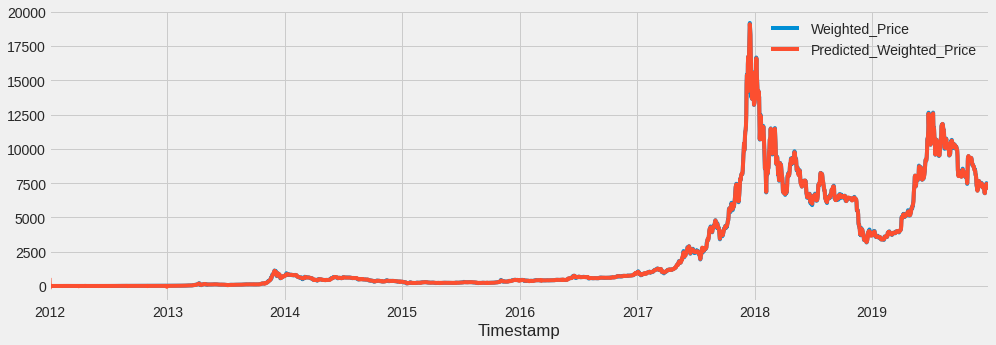

In [67]:
df_train['Predicted_Weighted_Price'] = model.predict(X_train)

df_train[['Weighted_Price','Predicted_Weighted_Price']].plot(figsize=(15, 5))

In [68]:
df_valid['Forecast_XGBoost'] = model.predict(X_test)

overall_data = pd.concat([df_train, df_valid], sort=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



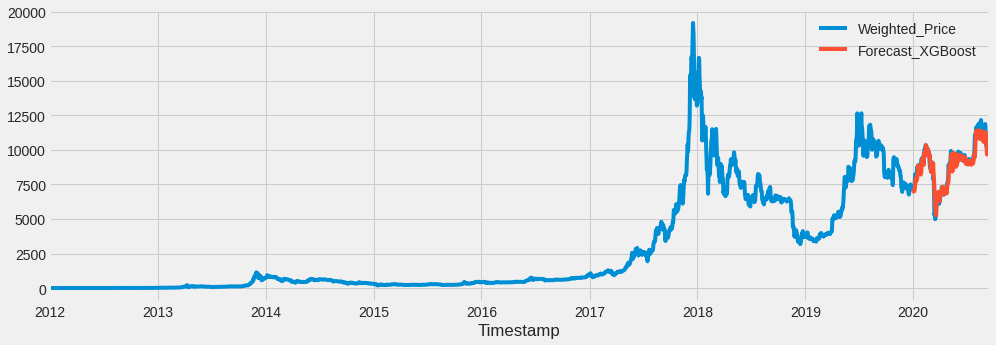

In [69]:
overall_data[['Weighted_Price','Forecast_XGBoost']].plot(figsize=(15, 5))

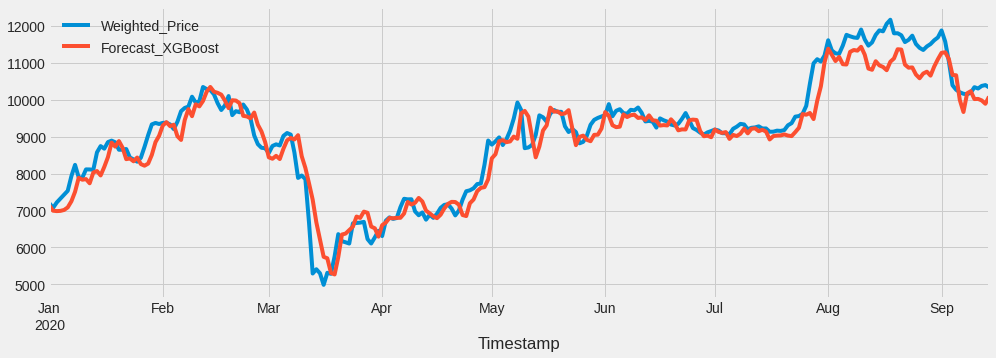

In [70]:
df_valid[['Weighted_Price','Forecast_XGBoost']].plot(figsize=(15, 5))

**Regression metrics**

The sklearn.metrics module implements several loss, score, and utility functions to measure regression performance. We will apply some of them:

1. **Mean absolute error** : The mean_absolute_error function computes mean absolute error, a risk metric corresponding to the expected value of the absolute error loss or L1-norm loss.

2. **Mean squared error** : The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared error.
 
3. **R² score, the coefficient of determination** : R-squared says how good your model fits the data. R-squared  closer to 1.0 says that the model fits the data quite well, whereas closer 0 means  that model isn’t that good. R-squared can also be negative when the model just  makes absurd predictions. 

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [72]:
train_mae = mean_absolute_error(df_train['Weighted_Price'], df_train['Predicted_Weighted_Price'])
train_rmse = np.sqrt(mean_squared_error(df_train['Weighted_Price'], df_train['Predicted_Weighted_Price']))
train_r2 = r2_score(df_train['Weighted_Price'], df_train['Predicted_Weighted_Price'])

print(f"train MAE : {train_mae}")
print(f"train RMSE : {train_rmse}")
print(f"train R2 : {train_r2}")

train MAE : 16.253116891889704
train RMSE : 30.043485859470486
train R2 : 0.9999300965754864


In [73]:
test_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost'])
test_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost']))
test_r2 = r2_score(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost'])

print(f"test MAE : {test_mae}")
print(f"test RMSE : {test_rmse}")
print(f"test R2 : {test_r2}")

test MAE : 335.790440934631
test RMSE : 452.3760738194467
test R2 : 0.9157643216438349


# Comparing Models

Text(0, 0.5, 'Bitcoin Price')

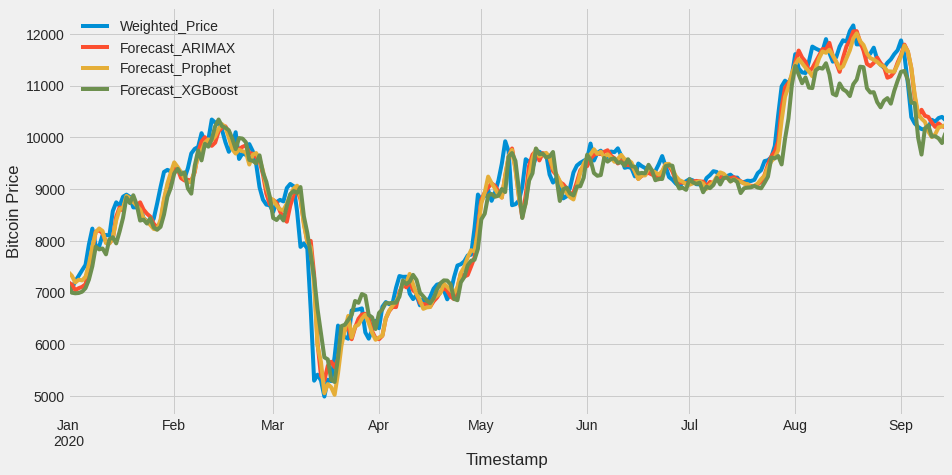

In [74]:
df_valid[["Weighted_Price", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_XGBoost"]].plot(figsize=(14,7))
plt.ylabel('Bitcoin Price')

In [75]:
arimax_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_ARIMAX']))
fbp_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_Prophet']))
xgb_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost']))

arimax_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_ARIMAX'])
fbp_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_Prophet'])
xgb_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost'])


print("ARIMAX RMSE :", arimax_rmse)
print("FB Prophet RMSE :", fbp_rmse)
print("XGBoost RMSE :", xgb_rmse)

print("\nARIMAX MAE :", arimax_mae)
print("FB Prophet MAE :", fbp_mae)
print("XGBoost MAE :", xgb_mae)

ARIMAX RMSE : 322.18643330459946
FB Prophet RMSE : 323.0097924038709
XGBoost RMSE : 452.3760738194467

ARIMAX MAE : 226.99840002996618
FB Prophet MAE : 229.59667095230242
XGBoost MAE : 335.790440934631


<a id="subsection-nine"></a>
# LSTM
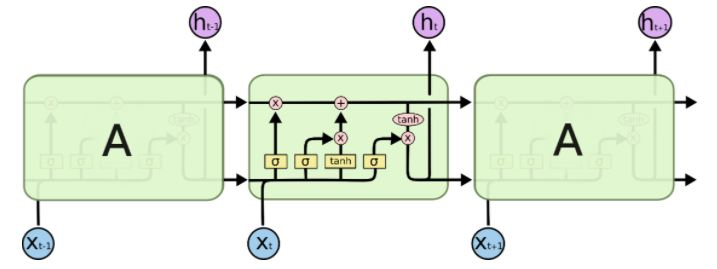

* **Long Short Term Memory networks** – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. 
* LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn like RNNs!
* All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.
* Also, they don't suffer from problems like **vanishing/exploding gradient descent**. 

To master the theory, refer this amazing article [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [76]:
price_series = bitstamp_daily.reset_index().Weighted_Price.values
price_series

array([4.47737025e+00, 4.76557639e+00, 5.00654859e+00, ...,
       1.03731430e+04, 1.03957982e+04, 1.03324294e+04])

In [77]:
price_series.shape

(3181,)

In [78]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
price_series_scaled = scaler.fit_transform(price_series.reshape(-1,1))

In [79]:
price_series_scaled, price_series_scaled.shape

(array([[6.08556702e-06],
        [2.11105388e-05],
        [3.36730766e-05],
        ...,
        [5.40552894e-01],
        [5.41733970e-01],
        [5.38430384e-01]]),
 (3181, 1))

In [80]:
train_data, test_data = price_series_scaled[0:2923], price_series_scaled[2923:]

In [81]:
test_data

array([[0.37491768],
       [0.36849274],
       [0.37605608],
       [0.38148647],
       [0.38712802],
       [0.39252016],
       [0.41317751],
       [0.42912486],
       [0.41155098],
       [0.41099899],
       [0.42274381],
       [0.42265234],
       [0.42219322],
       [0.44679055],
       [0.45560518],
       [0.45199251],
       [0.46129351],
       [0.46332625],
       [0.46101572],
       [0.4504458 ],
       [0.45052091],
       [0.45153659],
       [0.43955893],
       [0.4368209 ],
       [0.43359932],
       [0.43921931],
       [0.4545379 ],
       [0.47113893],
       [0.48622488],
       [0.48830269],
       [0.48681115],
       [0.48838555],
       [0.48862304],
       [0.48619293],
       [0.47954694],
       [0.48996769],
       [0.5049084 ],
       [0.50946061],
       [0.51134823],
       [0.5253092 ],
       [0.51705421],
       [0.51888869],
       [0.53904608],
       [0.53602273],
       [0.53476191],
       [0.52860138],
       [0.51617516],
       [0.506

In [82]:
# train_data = train_data.reshape(-1,1)
# test_data = test_data.reshape(-1,1)

In [83]:
train_data.shape, test_data.shape

((2923, 1), (258, 1))

In [84]:
def windowed_dataset(series, time_step):
    dataX, dataY = [], []
    for i in range(len(series)- time_step-1):
        a = series[i : (i+time_step), 0]
        dataX.append(a)
        dataY.append(series[i+ time_step, 0])
        
    return np.array(dataX), np.array(dataY)

In [85]:
X_train, y_train = windowed_dataset(train_data, time_step=100)
X_test, y_test = windowed_dataset(test_data, time_step=100)

In [86]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2822, 100), (2822,), (157, 100), (157,))

In [87]:
#reshape inputs to be [samples, timesteps, features] which is requred for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


print(X_train.shape) 
print(X_test.shape)

(2822, 100, 1)
(157, 100, 1)


In [88]:
print(y_train.shape) 
print(y_test.shape)

(2822,)
(157,)


In [89]:
#Create Stacked LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [90]:
# Initialising the LSTM
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [91]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [92]:
# Fitting the RNN to the Training set
history = regressor.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32, verbose=1, shuffle=False)

Epoch 1/100
80/80 [==============================] - 16s 195ms/step - loss: 0.0045 - val_loss: 0.0350
Epoch 2/100
80/80 [==============================] - 14s 172ms/step - loss: 0.0184 - val_loss: 0.0506
Epoch 3/100
80/80 [==============================] - 15s 182ms/step - loss: 0.0187 - val_loss: 0.0139
Epoch 4/100
80/80 [==============================] - 14s 174ms/step - loss: 0.0218 - val_loss: 0.0114
Epoch 5/100
80/80 [==============================] - 14s 177ms/step - loss: 0.0164 - val_loss: 0.0041
Epoch 6/100
80/80 [==============================] - 15s 183ms/step - loss: 0.0086 - val_loss: 0.0066
Epoch 7/100
80/80 [==============================] - 14s 177ms/step - loss: 0.0070 - val_loss: 0.0060
Epoch 8/100
80/80 [==============================] - 14s 176ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 9/100
80/80 [==============================] - 13s 167ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 10/100
80/80 [==============================] - 13s 165ms/step - loss: 0.003

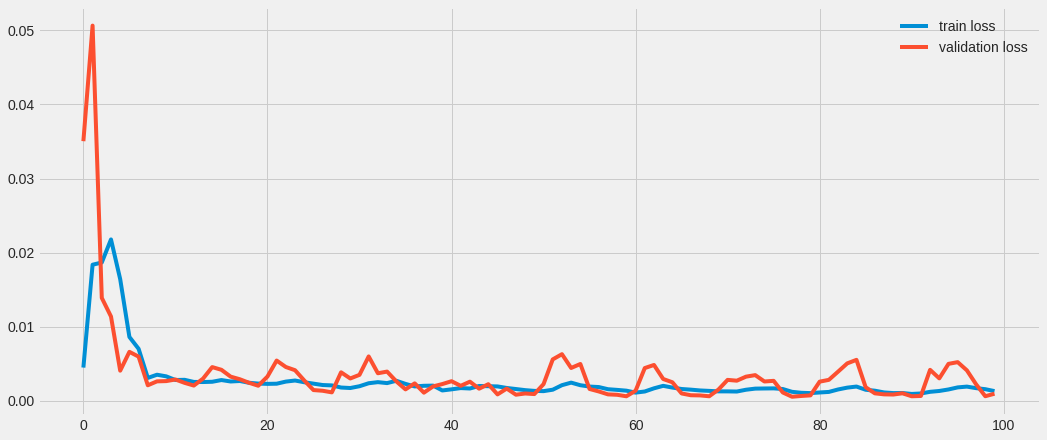

In [93]:
plt.figure(figsize=(16,7))
plt.plot(history.history["loss"], label= "train loss")
plt.plot(history.history["val_loss"], label= "validation loss")
plt.legend()

In [94]:
#Lets do the prediction and performance checking

train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [95]:
#transformation to original form

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
train_predict_inv = scaler.inverse_transform(train_predict)
test_predict_inv = scaler.inverse_transform(test_predict)

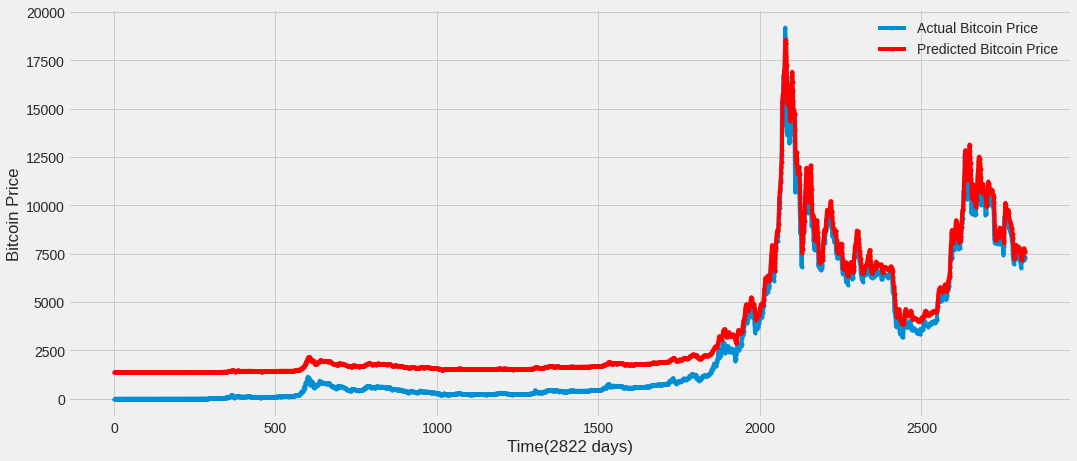

In [96]:
plt.figure(figsize=(16,7))
plt.plot(y_train_inv.flatten(), marker='.', label="Actual Bitcoin Price")
plt.plot(train_predict_inv.flatten(), 'r', marker='.', label="Predicted Bitcoin Price")
plt.xlabel('Time(2822 days)')
plt.ylabel('Bitcoin Price')
plt.legend()

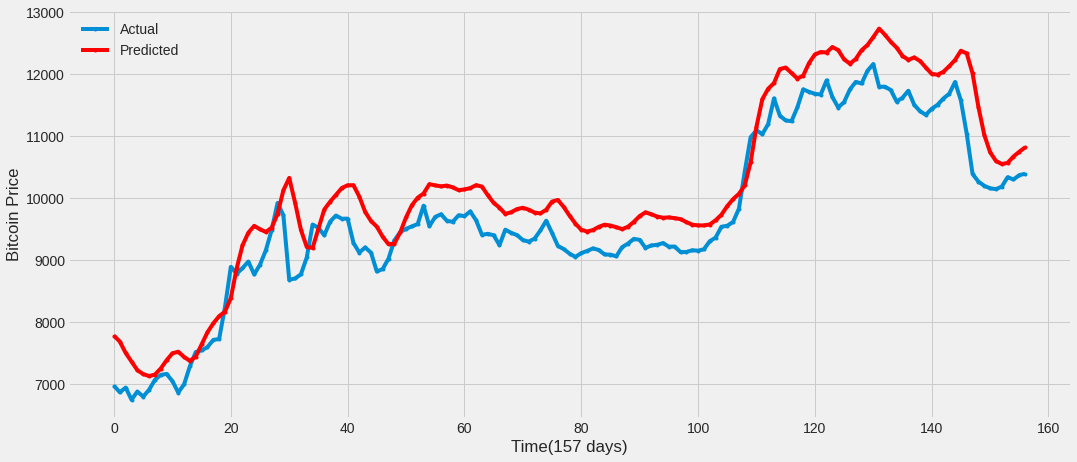

In [97]:
plt.figure(figsize=(16,7))
plt.plot(y_test_inv.flatten(), marker='.', label="Actual")
plt.plot(test_predict_inv.flatten(), 'r', marker='.', label="Predicted")
plt.xlabel('Time(157 days)')
plt.ylabel('Bitcoin Price')
plt.legend()

In [98]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

train_RMSE = np.sqrt(mean_squared_error(y_train_inv.flatten(), train_predict_inv.flatten()))
test_RMSE = np.sqrt(mean_squared_error(y_test_inv.flatten(), test_predict_inv.flatten()))
train_MAE = mean_absolute_error(y_train_inv.flatten(), train_predict_inv.flatten())
test_MAE = mean_absolute_error(y_test_inv.flatten(), test_predict_inv.flatten())
test_R2 = r2_score(y_test_inv.flatten(),test_predict_inv.flatten())

print(f"Train RMSE: {train_RMSE}")
print(f"Train MAE: {train_MAE}")

print(f"Test RMSE: {test_RMSE}")
print(f"Test MAE: {test_MAE}")
print(f"Test R2: {test_R2}")

Train RMSE: 1088.6676976686933
Train MAE: 1010.6786123285636
Test RMSE: 554.054457890126
Test MAE: 483.6566010778114
Test R2: 0.8317549157011904


<a id="section-seven"></a>
# Model Selection and Prediction

We observed remarkable results using LSTMs. They really work a lot better for most sequence tasks! 

Let's predict weighted price for next 30 days. 

In [99]:
test_data.shape

(258, 1)

In [100]:
lookback = len(test_data) - 100
x_input=test_data[lookback:].reshape(1,-1)
x_input.shape

(1, 100)

In [101]:
x_input

array([[0.50135107, 0.50680857, 0.50611375, 0.51004671, 0.50252873,
        0.49040564, 0.49122569, 0.49005254, 0.48172079, 0.49471156,
        0.49206669, 0.49014937, 0.48599147, 0.48468632, 0.48714124,
        0.49403472, 0.5022402 , 0.49195282, 0.4810431 , 0.47841309,
        0.47456507, 0.47184632, 0.47502431, 0.47683754, 0.47894088,
        0.47766879, 0.47386645, 0.47373395, 0.47231665, 0.48004879,
        0.4830018 , 0.48698126, 0.48615687, 0.47939465, 0.48143067,
        0.48199038, 0.48347641, 0.48044579, 0.48053383, 0.47585522,
        0.47598822, 0.47740834, 0.47704717, 0.47823839, 0.48499877,
        0.48802855, 0.49717381, 0.49801705, 0.50126549, 0.51243327,
        0.54377873, 0.5724569 , 0.57823839, 0.57498307, 0.58345498,
        0.60499713, 0.59060117, 0.58651106, 0.58593457, 0.59747987,
        0.61262317, 0.61058339, 0.60893581, 0.60829921, 0.62015157,
        0.60623057, 0.59740935, 0.60195372, 0.61260273, 0.6189534 ,
        0.61759268, 0.62824852, 0.63393972, 0.61

In [102]:
lookback, len(test_data)

(158, 258)

In [103]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.5013510655365931,
 0.5068085655581376,
 0.5061137476714964,
 0.5100467085119593,
 0.5025287305221985,
 0.49040564268682735,
 0.4912256871005408,
 0.4900525440407246,
 0.48172078652461797,
 0.49471155721375265,
 0.4920666869339218,
 0.49014937043770995,
 0.48599147284717864,
 0.4846863221380407,
 0.48714123563670314,
 0.49403471556030676,
 0.5022401983845729,
 0.49195282312057986,
 0.4810430972233209,
 0.4784130911861263,
 0.47456507107329476,
 0.47184631713472985,
 0.4750243082765881,
 0.47683754319348753,
 0.478940880437832,
 0.4776687916685904,
 0.47386645325764604,
 0.47373394997816354,
 0.472316648728742,
 0.4800487921231013,
 0.48300179669796167,
 0.4869812585071819,
 0.4861568747371747,
 0.4793946536451497,
 0.48143067340597223,
 0.4819903772045721,
 0.48347640745911813,
 0.4804457907713098,
 0.48053383331012794,
 0.47585522119656914,
 0.47598822202217017,
 0.477408336072757,
 0.4770471695992191,
 0.4782383872965043,
 0.48499877150383064,
 0.4880285456929929,
 0.49717381332905

In [104]:
len(temp_input)

100

In [105]:
# demonstrate prediction for next 100 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = regressor.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = regressor.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.56650335]
101
1 day input [0.50680857 0.50611375 0.51004671 0.50252873 0.49040564 0.49122569
 0.49005254 0.48172079 0.49471156 0.49206669 0.49014937 0.48599147
 0.48468632 0.48714124 0.49403472 0.5022402  0.49195282 0.4810431
 0.47841309 0.47456507 0.47184632 0.47502431 0.47683754 0.47894088
 0.47766879 0.47386645 0.47373395 0.47231665 0.48004879 0.4830018
 0.48698126 0.48615687 0.47939465 0.48143067 0.48199038 0.48347641
 0.48044579 0.48053383 0.47585522 0.47598822 0.47740834 0.47704717
 0.47823839 0.48499877 0.48802855 0.49717381 0.49801705 0.50126549
 0.51243327 0.54377873 0.5724569  0.57823839 0.57498307 0.58345498
 0.60499713 0.59060117 0.58651106 0.58593457 0.59747987 0.61262317
 0.61058339 0.60893581 0.60829921 0.62015157 0.60623057 0.59740935
 0.60195372 0.61260273 0.6189534  0.61759268 0.62824852 0.63393972
 0.61480937 0.61490586 0.61203588 0.60242505 0.60560053 0.61149789
 0.59976336 0.59427395 0.59128622 0.59629928 0.59967768 0.60496833
 0.60894375 0.61883331 0.60330389 0

In [106]:
len(price_series_scaled)

3181

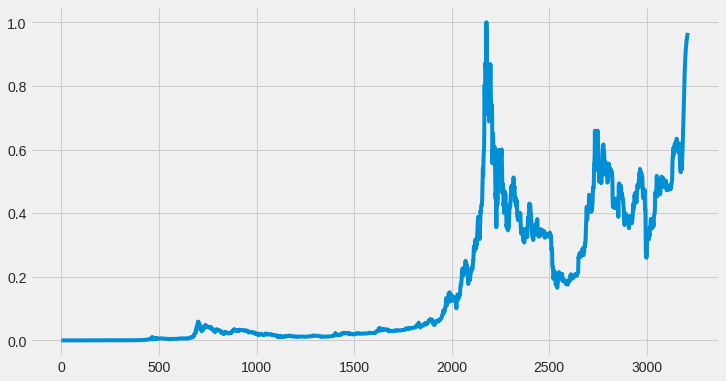

In [107]:
df_=price_series_scaled.tolist()
df_.extend(lst_output)
plt.plot(df_)

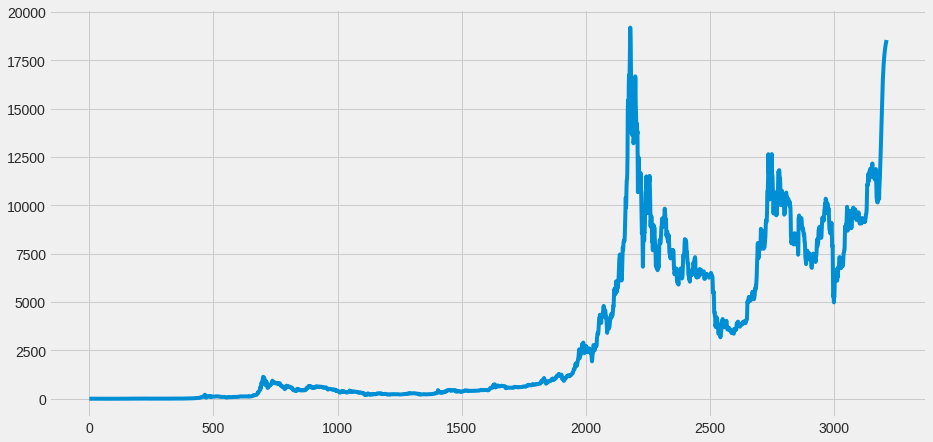

In [108]:
plt.figure(figsize=(14,7))
df_invscaled=scaler.inverse_transform(df_).tolist()
plt.plot(df_invscaled)

<a id="section-eight"></a>
# Next Steps

- We can increase the number of epochs to refine our model performance, you can increase epochs to 100 and can the results. Also, number of lag features can be increased beyond 100 to help learning the model. 
- I will use  LSTM Autoencoders for Anomaly Detection in Time Series.

Please keep an eye on this notebook and ***Upvote*** if you learnt something new from this :)